#  This is Lab 2 executable file
This file contains the program code that is the solution to the tasks from the file [lab_2_task.txt](https://github.com/vandosik/M-M-MSA/blob/master/Lab_2/lab_2_task.txt).
## Authors
* Ivan Dubinin: [vandosik](https://github.com/vandosik)
* Alexey Grandilevskii: [zer0deck](https://github.com/zer0deck)
* Mikhail Sorokin: [Mikha1lSorokin](https://github.com/Mikha1lSorokin)

In [28]:
# libs initialization
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
import pandas as pd
import numpy as np
import scipy as sp

from datetime import datetime
from prettytable import PrettyTable

from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
# Dataset initialization
path_to_file = '../Datasets/Challenger_Ranked_Games.csv'
source_df = pd.read_csv(path_to_file, engine='python')
# source_df.columns = ["V"+str(i) for i in range(1, len(source_df.columns)+1)]  # rename column names to be similar to R naming convention
# source_df.V2 = source_df.V2.astype(str)
source_df.head(7)

,gameId,gameDuraton,blueWins,blueFirstBlood,blueFirstTower,blueFirstBaron,blueFirstDragon,blueFirstInhibitor,blueDragonKills,blueBaronKills,...,redAssist,redChampionDamageDealt,redTotalGold,redTotalMinionKills,redTotalLevel,redAvgLevel,redJungleMinionKills,redKillingSpree,redTotalHeal,redObjectDamageDealt
0,4247263043,1323,0,1,0,0,0,0,0,0,...,68,73016,49832,533,64,12.8,138,8,38711,60463
1,4247155821,1317,1,0,0,0,1,0,2,0,...,8,44218,37136,571,59,11.8,134,3,24829,14105
2,4243963257,932,0,0,0,0,0,0,0,0,...,20,30797,35364,400,50,10.0,89,5,12589,45201
3,4241678498,2098,0,0,0,1,1,0,1,1,...,72,125866,70528,832,84,16.8,205,9,65312,88202
4,4241538868,2344,1,1,1,1,1,1,2,2,...,83,131536,74596,794,85,17.0,227,7,86431,64141
5,4241394461,1567,1,1,1,0,0,1,2,0,...,34,64242,44280,555,61,12.2,140,3,23741,20132
6,4233222221,1686,0,0,1,0,0,0,0,0,...,59,78424,58032,640,73,14.6,214,5,31415,61040


Date:        date and time the game was auto-played

Level:       the 3-digit number is an estimate of the difficulty from a previous run

NumBlocks:   how many blocks have to be broken to win the level

IsWin:       True if autoplay broke all the blocks, False if the ball fell past the paddle

ElapsedTime: Seconds until either won or lost (game is played at 4x speed, so multiply by 4 to get an estimate of how long a human might play it)

Score:       total score when the game was won or lost

Accuracy:    the autoplay is tuned with a randomly-chosen accuracy. Higher numbers are more likely to win;

In [3]:
# Colums renaming and data preparation

# # Recretion of timestamps columns in length of the game column
# source_df['round_start_time'] = source_df['round_start_time'].astype(str)
# source_df['round_end_time'] = source_df['round_end_time'].astype(str)
# glength = []
# for i in range(0, len(source_df['round_start_time'])):
#     finaltime = datetime.strptime(source_df['round_end_time'][i], '%Y-%m-%d %H:%M:%S')
#     starttime = datetime.strptime(source_df['round_start_time'][i], '%Y-%m-%d %H:%M:%S')
#     td = finaltime - starttime
#     glength.append(td.seconds)
# source_df['game_length'] = glength
# source_df['game_length'] = source_df['game_length'].astype(int)

# deleting unused columns
# source_df = source_df.drop(['round_start_time', 'round_end_time', 'match_id', 'attacker_control_perecent',	'defender_control_perecent', 'team_one_name', 'team_two_name', 'control_round_name'], axis = 1)
source_df = source_df[['gameDuraton', # this is the value we will predict (target)
                        'blueWins', # this is our category sorter
                        'blueWardPlaced', # all other values are the predictors
                        'blueWardkills', 
                        'blueKills', 
                        'blueDeath', 
                        'blueChampionDamageDealt', 
                        'blueTotalGold', 
                        'blueTotalMinionKills', 
                        'blueJungleMinionKills',
                        'blueTotalHeal',
                        'blueObjectDamageDealt']]

# show new dataset
source_df.head(7)


,gameDuraton,blueWins,blueWardPlaced,blueWardkills,blueKills,blueDeath,blueChampionDamageDealt,blueTotalGold,blueTotalMinionKills,blueJungleMinionKills,blueTotalHeal,blueObjectDamageDealt
0,1323,0,38,13,15,31,56039,37001,440,105,31035,5675
1,1317,1,57,18,19,8,60243,41072,531,111,26397,45303
2,932,0,28,7,5,20,24014,22929,306,64,6567,5651
3,2098,0,129,39,26,36,101607,63447,774,226,24718,31019
4,2344,1,114,35,27,40,134826,74955,831,252,37161,95287
5,1567,1,65,23,26,18,59839,52221,576,171,40925,51855
6,1686,0,72,26,16,31,70270,47107,601,136,20503,31788


In [4]:
# plt.figure(figsize=(13, 8))

# kernel = scipy.stats.gaussian_kde(source_df['game_length'])

# min_amount, max_amount = source_df['game_length'].min(), source_df['game_length'].max()
# x = np.linspace(min_amount, max_amount, len(source_df)) # by defaul 50 items
# kde_values = kernel(x)

# # sns.histplot(source_df[col_name], kde=False, stat="density", label=f'Average transaction size in rubles')
# # Draw unnormed histogramm
# hist_data = plt.hist(source_df['game_length'], density=True, bins=50)

# # print(hist_vals)
# plt.plot(x, kde_values, color="r")

# plt.ylabel('p')
# plt.xlabel('Average transaction size')

# plt.legend()
# plt.show()

## Exercise №1
You need to make a non-parametric estimation of PDF in form of histogram and using kernel density function for MRV (or probability law in case of discrete MRV).

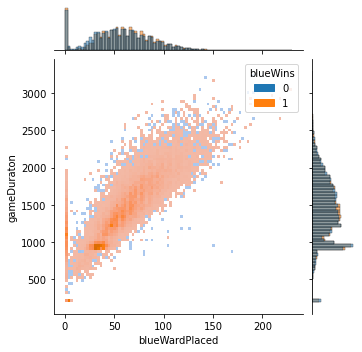

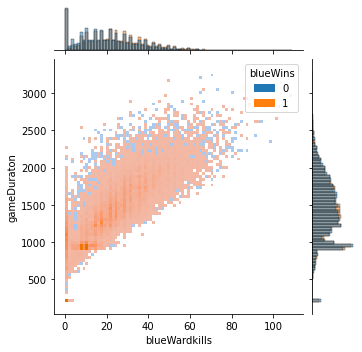

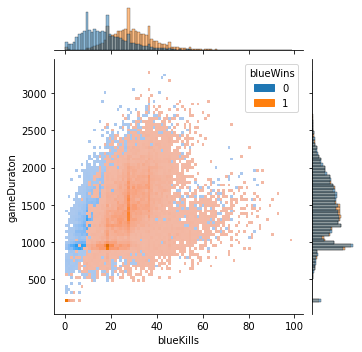

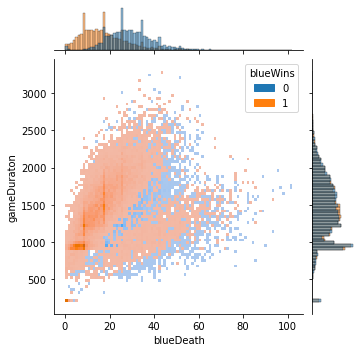

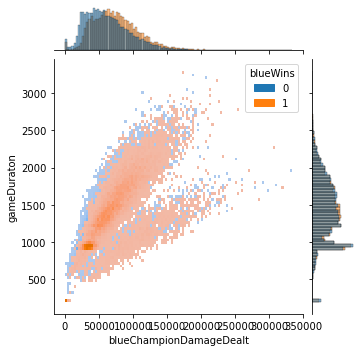

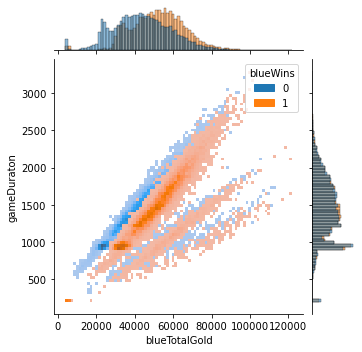

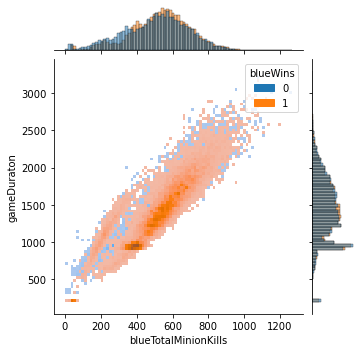

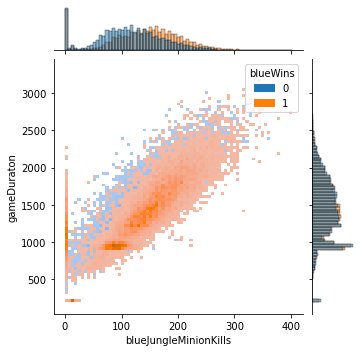

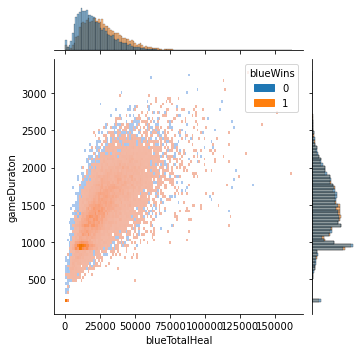

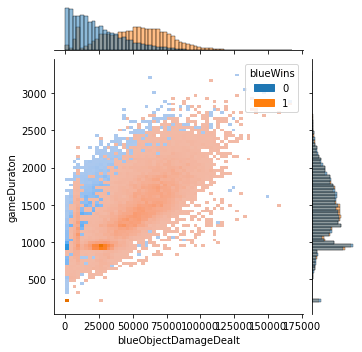

In [5]:
ilist = source_df.columns.tolist()
for i in range(2, len(ilist)):
    sns.jointplot(data=source_df, x=ilist[i], y='gameDuraton', hue='blueWins', height=5, kind="hist")
    

## Exercise №2
You need to make an estimation of multivariate mathematical expectation and variance.

In [6]:
table = PrettyTable()
table.field_names = ["Column name", "mathematical expectation", "variance"]
for i in range(0, len(ilist)-1):
    table.add_row([str(ilist[i]), str(source_df.mean()[i]), str(source_df.var()[i])])
print(table)

+-------------------------+--------------------------+---------------------+
|       Column name       | mathematical expectation |       variance      |
+-------------------------+--------------------------+---------------------+
|       gameDuraton       |    1448.6536574487066    |   178571.564389849  |
|         blueWins        |    0.5000743383883437    | 0.25000928711754167 |
|      blueWardPlaced     |    58.64035087719298     |  982.9231697241096  |
|      blueWardkills      |    22.330136782634554    |  240.32047448599184 |
|        blueKills        |    24.18941421349985     |  167.81358009025033 |
|        blueDeath        |    24.180567945286946    |  170.11615064943672 |
| blueChampionDamageDealt |    69746.34188224799     |   1279018982.99139  |
|      blueTotalGold      |    48169.129906333634    |  239513867.6275128  |
|   blueTotalMinionKills  |     520.446587867975     |  30965.83865170302  |
|  blueJungleMinionKills  |     129.586938745168     |  4181.303298898823  |

## Exercise №3
You need to make a non-parametric estimation of conditional distributions, mathematical expectations and variances. 

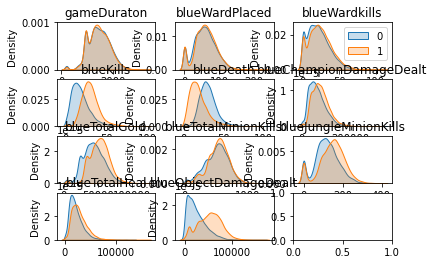

In [15]:
# list of variables without bluewins
w = ['gameDuraton',
    'blueWardPlaced',
    'blueWardkills', 
    'blueKills', 
    'blueDeath', 
    'blueChampionDamageDealt', 
    'blueTotalGold', 
    'blueTotalMinionKills', 
    'blueJungleMinionKills',
    'blueTotalHeal',
    'blueObjectDamageDealt']

# we make only 5 most popular maps estimation otherwise the graphs will become unreadable
# fig = plt.figure(figsize=(25,15))
plt.subplots(4, 3)
for i, col in enumerate(w):
    plt.subplot(4, 3, i+1)
    sns.kdeplot(source_df.loc[source_df['blueWins'] == 0, col], shade=True, label='0', warn_singular=False)
    sns.kdeplot(source_df.loc[source_df['blueWins'] == 1, col], shade=True, label="1", warn_singular=False)
    plt.xlabel('')
    plt.title(col)
    if i == 2:
        plt.legend(loc='upper right')
    else:
        plt.legend().remove()
plt.show()

In [19]:
# output mean and var grouped by maps
bluewins_df = source_df.groupby('blueWins')
table = PrettyTable()
table.field_names = ["Win or not", "Column name", "m.expectation", "variance"]
for blueWins, group in bluewins_df:
    table.add_row([blueWins, w[0], str(group[w[0]].mean())[:10], str(group[w[0]].var())[:10]])
    for i in range (1, len(w)):
        table.add_row(['', w[i], str(group[w[i]].mean())[:10], str(group[w[i]].var())[:10]])
table.align["Column name"] = 'l'
print(table)

+------------+-------------------------+---------------+------------+
| Win or not | Column name             | m.expectation |  variance  |
+------------+-------------------------+---------------+------------+
|     0      | gameDuraton             |   1449.25144  | 181851.478 |
|            | blueWardPlaced          |   57.4631970  | 985.511211 |
|            | blueWardkills           |   21.2373234  | 230.256410 |
|            | blueKills               |   18.3136059  | 136.538866 |
|            | blueDeath               |   29.9173234  | 131.714927 |
|            | blueChampionDamageDealt |   63301.6408  | 1216631860 |
|            | blueTotalGold           |   43889.6875  | 239328282. |
|            | blueTotalMinionKills    |   506.568847  | 33365.2066 |
|            | blueJungleMinionKills   |   116.153011  | 3668.88103 |
|            | blueTotalHeal           |   21790.4883  | 189946343. |
|            | blueObjectDamageDealt   |   24563.3782  | 396906863. |
|     1      | gameD

## Exercise №4
You need to make an estimation of pair correlation coefficients, confidence intervals for them and significance levels.

In [21]:
table = PrettyTable()
table.field_names = ["Variable", "Corr coefficient", "Significance level", "Confidence interval"]
for variable in w[1:]:
  r, p = sp.stats.pearsonr(source_df[variable], source_df['gameDuraton'])
  low = np.arctanh(r) - sp.stats.norm.ppf(0.475) / np.sqrt(source_df[variable].size - 3)
  high = np.arctanh(r) + sp.stats.norm.ppf(0.475) / np.sqrt(source_df[variable].size - 3)
  st, fin = np.tanh((low, high))
  table.add_row([variable, str(r)[:7], str(p)[:7], f"[{st} ... {fin}]"])
table.align = 'l'
table.align["Corr coefficient"] = 'r'
table.align["Significance level"] = 'r'
print(table)

+-------------------------+------------------+--------------------+---------------------------------------------+
| Variable                | Corr coefficient | Significance level | Confidence interval                         |
+-------------------------+------------------+--------------------+---------------------------------------------+
| blueWardPlaced          |          0.84068 |                0.0 | [0.8407969440125066 ... 0.8405727124350015] |
| blueWardkills           |          0.80495 |                0.0 | [0.8050915612888213 ... 0.804822372169526]  |
| blueKills               |          0.36672 |                0.0 | [0.3670546857349305 ... 0.366392874446079]  |
| blueDeath               |          0.37405 |                0.0 | [0.3743882568922436 ... 0.3737306007844456] |
| blueChampionDamageDealt |          0.68465 |                0.0 | [0.6848618641984793 ... 0.6844556520231687] |
| blueTotalGold           |          0.77683 |                0.0 | [0.7769865142939417 

## Exercise №5
Choose a task formulation for regression. Estimate multivariate correlation (target - predictors).

Text(0.5, 1.0, 'Multivariate correlation matrix')

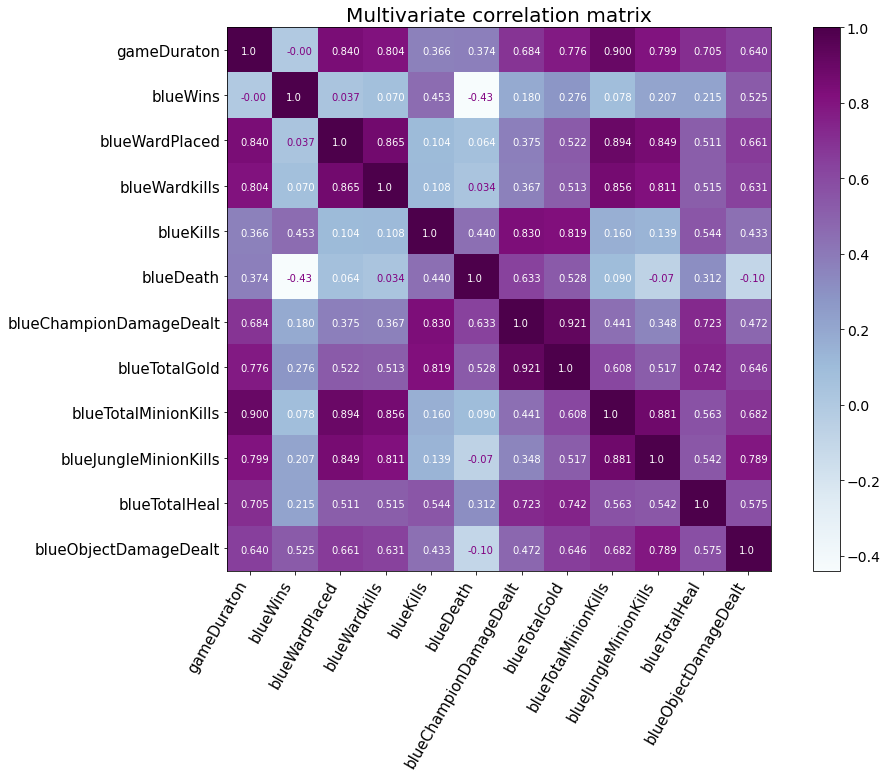

In [23]:
plt.figure(figsize=(15, 10))
corr_m = np.array(source_df.corr())
# print(corr_m)
plt.imshow(corr_m, cmap='BuPu')
ax = plt.subplot()
for i in range(0, 12):
    for j in range(0, 12):
        if corr_m[i,j]<0.05:
                ax.text(-0.2+i, 0.1+j, str(corr_m[i,j])[:5], fontsize = 10, color='purple')
        else:
                ax.text(-0.2+i, 0.1+j, str(corr_m[i,j])[:5], fontsize = 10, color='white')
        # ax.text(0.6, 0.1, str(corr_m[1,0])[:5], fontsize = 20)
# plt.matshow(source_df.corr(), fignum=f.number)
plt.yticks(range(source_df.select_dtypes(['number']).shape[1]), source_df.select_dtypes(['number']).columns, fontsize=15)
plt.xticks(range(source_df.select_dtypes(['number']).shape[1]), source_df.select_dtypes(['number']).columns, fontsize=15, rotation=60, horizontalalignment='right')
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Multivariate correlation matrix', fontsize=20)

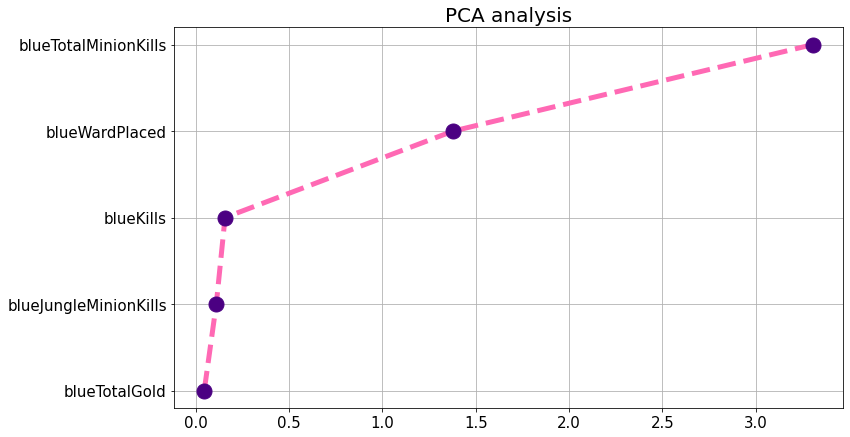

In [29]:
w = ['gameDuraton',
    'blueWardPlaced',
    'blueWardkills', 
    'blueKills', 
    'blueDeath', 
    'blueChampionDamageDealt', 
    'blueTotalGold', 
    'blueTotalMinionKills', 
    'blueJungleMinionKills',
    'blueTotalHeal',
    'blueObjectDamageDealt']
pca_df = source_df[['blueTotalMinionKills', 
                    'blueWardPlaced',
                    'blueKills',                    
                    'blueJungleMinionKills',
                    'blueTotalGold',]]
pca_vars = sk.preprocessing.scale(pca_df)
pca_vars = pd.DataFrame(pca_vars, index=pca_df.index, columns=pca_df.columns)

plt.figure(figsize=(12,7))
pca = PCA().fit(pca_vars)
x = np.std(pca.transform(pca_vars), axis=0)**2
y = - np.arange(len(x)) - 1
plt.plot(x, y, "o", markersize=15, markerfacecolor='indigo', markeredgecolor='indigo', linewidth=5, linestyle='--', color='hotpink')
plt.grid(True)
plt.yticks(y, pca_vars.columns, fontsize=15)
plt.xticks(fontsize=15)
plt.title('PCA analysis', fontsize=20)
plt.show()

## Exercise №6
Build regression model and make an analysis of multicollinearity and regularization (if needed). 

In [85]:
X_train, X_test, y_train, y_test = sk.model_selection.train_test_split (source_df['attacker_round_end_score'], 
                                                                        source_df[['winning_team_final_map_score', 
                                                                                    'losing_team_final_map_score',
                                                                                    'map_round',                    
                                                                                    'defender_round_end_score',]], 
                                                                        test_size=0.15, random_state=42)

## Exercise №7
Analyze the quality of regression model (distribution of residuals, determination coefficient).